## Initialize

In [1]:
#library(Rmisc)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(ggdist)
library(ggtext)
library(ggforestplot)
library(cowplot)

Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘arrow’ was built under R version 4.0.3”

Attaching package: ‘arrow’


The following object is masked from ‘p

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

dataset_name = "210714_metabolomics"
path = "/data/analysis/ag-reils/steinfej/code/umbrella/pre/ukbb"
data_path = glue("{base_path}/data")
dataset_path = glue("{data_path}/3_datasets_post/{dataset_name}")

project_label="21_metabolomics_multitask"
project_path = glue("{base_path}/results/projects/{project_label}")
figures_path = glue("{project_path}/figures")
data_results_path = glue("{project_path}/data")

[1] "/sc-projects/sc-proj-ukb-cvd"


## Load data

In [3]:
list.dirs(path = project_path, full.names = TRUE, recursive = TRUE)

[1] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask"                                         
[2] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/data"                                    
[3] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures"                                 
[4] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures/.ipynb_checkpoints"              
[5] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures/UMAP"                            
[6] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures/UMAP/basics"                     
[7] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures/UMAP/basics/.ipynb_checkpoints"  
[8] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures/UMAP/endpoint"                   
[9] "/sc-projects/sc-proj-ukb-cvd/results/projects/21_metabolomics_multitask/figures/UMAP/endpoint/.ipynb_checkpoints"

In [4]:
run = "211007"

In [5]:
DSM = "MultiTaskSurvivalTraining"
data = arrow::read_feather(glue("{dataset_path}/data_merged.feather")) 
data_description = arrow::read_feather(glue("{dataset_path}/description_merged.feather"))

In [6]:
library(ggalt)

Warning message:
“package ‘ggalt’ was built under R version 4.0.5”
Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2



In [7]:
library("jsonlite")
colors_path = "colors.json"
colors_dict = read_json(colors_path)

Warning message:
“package ‘jsonlite’ was built under R version 4.0.3”

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [8]:
color_map <- c("all" = "grey", "none" = "black",
          
               "SCORE_SCORE2" = colors_dict$pastel$grey$light, 
               'SCORE_ASCVD' = colors_dict$pastel$grey$mid, 
    
               
               'COX_Age+Sex' = colors_dict$pastel$grey$light, 
               
               'PCA_Metabolomics' = "#4F8EC1",
               'COX_Metabolomics' = "#4F8EC1",
               'DS_Metabolomics' = "#4F8EC1",  
               
                'COX_SCORE2' = colors_dict$pastel$grey$light, 
               'COX_ASCVD' = colors_dict$pastel$grey$light, 
 
               'COX_PANEL' = colors_dict$pastel$grey$light, 
  
               'DS_Age+Sex+Metabolomics' = "#53dd6c",#colors_dict$pastel$orange$mid,
               'DS_SCORE2+Metabolomics' = colors_dict$pastel$red$mid,
               'DS_ASCVD+Metabolomics' = "#d8315b",#colors_dict$pastel$red$mid,

               'DS_PANEL+Metabolomics' = "#1e1b18" #colors_dict$pastel$red$dark
      )

In [9]:
scores_full = names(color_map)

In [10]:
name = glue("benchmark1000_cindex_subgroups_220106")
benchmark_cindex_sg = read_feather(glue("{data_results_path}/{name}.feather"))  %>% distinct() %>% unite("score", c(module, features), remove=FALSE) %>%  distinct()

In [11]:
base_size = 8
title_size = 8
facet_size = 8
geom_text_size=3
library(ggplot2); 
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=8), axis.text=element_text(size=8, color="black"), axis.text.x=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2)))

In [12]:
library(ggthemes)
endpoint_map = c(
    'M_MACE'='MACE',
    'M_all_cause_dementia'='Dementia',
    'M_type_2_diabetes'='T2 Diabetes',
    'M_liver_disease'='Liver Disease',
    'M_renal_disease'='Renal Disease',
    'M_atrial_fibrillation'='Atrial Fibrillation',
    'M_heart_failure'= 'Heart Failure',
    'M_coronary_heart_disease'='CHD',
    'M_venous_thrombosis'='Ven. Thrombosis',
    'M_cerebral_stroke'='Cerebral Stroke',
    'M_abdominal_aortic_aneurysm'='AAA',
    'M_peripheral_arterial_disease'='PAD',
    "M_chronic_obstructuve_pulmonary_disease" = "COPD",
    "M_asthma" = "Asthma",
    'M_parkinsons_disease' = "Parkinson's",    
    "M_lung_cancer" = "Lung Cancer",
    "M_non_melanoma_skin_cancer" = "Skin Cancer",
    "M_colon_cancer"= "Colon Cancer",
    "M_rectal_cancer" = "Rectal Cancer",
    "M_prostate_cancer"= "Prostate Cancer",
    "M_breast_cancer" = "Breast Cancer",
    'M_cataracts' = "Cataracts", 
    'M_glaucoma' = "Glaucoma",
    'M_fractures' = "Fractures"
)

endpoint_order = c("M_MACE", "M_coronary_heart_disease", "M_cerebral_stroke", "M_all_cause_dementia", "M_heart_failure", "M_atrial_fibrillation",
                   "M_type_2_diabetes", "M_liver_disease", "M_renal_disease", "M_peripheral_arterial_disease", "M_venous_thrombosis",  "M_abdominal_aortic_aneurysm",
                   "M_chronic_obstructuve_pulmonary_disease", "M_asthma", 'M_parkinsons_disease', 'M_cataracts', 'M_glaucoma', 'M_fractures',
                    "M_lung_cancer","M_non_melanoma_skin_cancer","M_colon_cancer","M_rectal_cancer","M_prostate_cancer","M_breast_cancer"
                   
)

Warning message:
“package ‘ggthemes’ was built under R version 4.0.3”

Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map




In [13]:
eids_included = c()
for (endpoint in endpoint_order){
    data_temp = data %>% filter(NMR_FLAG==TRUE)
    endpoint_label = glue("{endpoint}")
    eids = (data_temp %>% filter(!!sym(endpoint_label)==0))$eid
    if (endpoint=="M_MACE"){eids = (data_temp %>% filter(!!sym(endpoint_label)==0&statins==0))$eid} 
    if (endpoint=="M_breast_cancer"){eids = (data_temp %>% filter(!!sym(endpoint_label)==0&sex=="Female"))$eid} 
    if (endpoint=="M_prostate_cancer"){eids = (data_temp %>% filter(!!sym(endpoint_label)==0&sex=="Male"))$eid} 
    eids_included[[endpoint]] = eids

    }

In [14]:
em_wrap = endpoint_map
em_wrap[names(endpoint_map)] <- str_wrap(unname(endpoint_map), 20)
em_wrap

M_MACE                    M_all_cause_dementia 
                                 "MACE"                              "Dementia" 
                      M_type_2_diabetes                         M_liver_disease 
                          "T2 Diabetes"                         "Liver Disease" 
                        M_renal_disease                   M_atrial_fibrillation 
                        "Renal Disease"                   "Atrial Fibrillation" 
                        M_heart_failure                M_coronary_heart_disease 
                        "Heart Failure"                                   "CHD" 
                    M_venous_thrombosis                       M_cerebral_stroke 
                      "Ven. Thrombosis"                       "Cerebral Stroke" 
            M_abdominal_aortic_aneurysm           M_peripheral_arterial_disease 
                                  "AAA"                                   "PAD" 
M_chronic_obstructuve_pulmonary_disease                                M_asthma 
                                 "COPD"                                "Asthma" 
                   M_parkinsons_disease                           M_lung_cancer 
                          "Parkinson's"                           "Lung Cancer" 
             M_non_melanoma_skin_cancer                          M_colon_cancer 
                          "Skin Cancer"                          "Colon Cancer" 
                        M_rectal_cancer                       M_prostate_cancer 
                        "Rectal Cancer"                       "Prostate Cancer" 
                        M_breast_cancer                             M_cataracts 
                        "Breast Cancer"                             "Cataracts" 
                             M_glaucoma                             M_fractures 
                             "Glaucoma"                             "Fractures"

In [78]:
options(repr.plot.width = 8, repr.plot.height = 8)
library(ggbeeswarm)
scores_plot = names(color_map)

temp = benchmark_cindex_sg %>% 
    mutate_at(vars(score), list(~ factor(., levels=scores_full))) %>% filter(score==score) %>% filter(score %in% scores_plot)
temp_wide = temp %>% select(-module, -features) %>% pivot_wider(names_from="score", values_from="cindex") %>% mutate(delta=`DS_Metabolomics`-`COX_Age+Sex`)
temp_desc = temp %>% group_by(endpoint, score) %>% summarise(mean=median(cindex, na.rm=TRUE), max = max(cindex), .groups="drop")
temp_desc = temp_desc %>% select(-max) %>% pivot_wider(names_from="score", values_from="mean") %>% mutate(delta=`DS_Metabolomics`-`COX_Age+Sex`) %>% mutate(endpoint=fct_reorder(endpoint, desc(delta)))
endpoint_order_desc = levels(temp_desc$endpoint)

In [79]:
scores_map = c(
    "DS_Metabolomics" = "MET",
    "COX_Age+Sex" = "AgeSex",
    "DS_Age+Sex+Metabolomics" = "AgeSex+MET",
    "COX_ASCVD" = "ASCVD",
    "DS_ASCVD+Metabolomics" = "ASCVD+MET",
    "COX_PANEL" = "PANEL", 
    "DS_PANEL+Metabolomics" = "PANEL+MET"
               )

## Figure 3 - Performance in Context

In [80]:
library(scales)

In [81]:
plot_width=8.25; plot_height=5.5; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)

scores_plot = c(
    "DS_Metabolomics",
    "COX_Age+Sex",
    "DS_Age+Sex+Metabolomics",
    "COX_ASCVD",
    "DS_ASCVD+Metabolomics",
    "COX_PANEL", 
    "DS_PANEL+Metabolomics"
               )

endpoint_order = c("M_MACE", "M_coronary_heart_disease", "M_cerebral_stroke", "M_all_cause_dementia", "M_heart_failure", "M_atrial_fibrillation",
                   "M_type_2_diabetes", "M_liver_disease", "M_renal_disease", "M_peripheral_arterial_disease", "M_venous_thrombosis",  "M_abdominal_aortic_aneurysm",
                   "M_chronic_obstructuve_pulmonary_disease", "M_asthma", 'M_parkinsons_disease', 'M_cataracts', 'M_glaucoma', 'M_fractures',
                    "M_lung_cancer","M_non_melanoma_skin_cancer","M_colon_cancer","M_rectal_cancer","M_prostate_cancer","M_breast_cancer"     
)

In [82]:
library(tidybayes)

In [83]:
## check that cohort sums up!
temp %>% group_by(endpoint, score, group, iteration) %>% summarise(sum(len_sg)) %>% filter(iteration==0) %>% ungroup() %>% sample_n(3)

`summarise()` has grouped output by 'endpoint', 'score', 'group'. You can override using the `.groups` argument.



endpoint,score,group,iteration,sum(len_sg)
<chr>,<fct>,<chr>,<int>,<int>
M_breast_cancer,COX_ASCVD,sex,0,62009
M_parkinsons_disease,COX_ASCVD,sex,0,117764
M_atrial_fibrillation,COX_Metabolomics,sex,0,116026


In [84]:
group_map = c(
    "age"="Age",
    "sex"="Biological\nSex",
    "ethnic_background"="Ethnic\nBackground")

In [85]:
endpoint_order %>% head(12)

[1] "M_MACE"                        "M_coronary_heart_disease"     
 [3] "M_cerebral_stroke"             "M_all_cause_dementia"         
 [5] "M_heart_failure"               "M_atrial_fibrillation"        
 [7] "M_type_2_diabetes"             "M_liver_disease"              
 [9] "M_renal_disease"               "M_peripheral_arterial_disease"
[11] "M_venous_thrombosis"           "M_abdominal_aortic_aneurysm"

## Get Subgroup information

In [86]:
data_prev = data %>% select(eid, all_of(endpoint_order)) %>% pivot_longer(all_of(endpoint_order), names_to="endpoint", values_to="prev")

In [106]:
data_event = data %>% select(eid, ends_with("_event")) %>% 
    pivot_longer(ends_with("_event"), names_to="endpoint", values_to="event") %>% 
    mutate(endpoint = str_replace_all(endpoint, "_event", ""))
data_event_time = data %>% select(eid, ends_with("_event_time")) %>% 
    pivot_longer(ends_with("_event_time"), names_to="endpoint", values_to="event_time") %>% 
    mutate(endpoint = str_replace_all(endpoint, "_event_time", ""))

In [88]:
data_n_event = data_event %>% left_join(data_prev, by=c("eid", "endpoint")) %>% left_join(data_event_time, by=c("eid", "endpoint")) %>% 
    mutate(event_10 = case_when(event==0 ~ 0, event==1&event_time>10 ~ 0, event==1&event_time<=10 ~1)) %>% 
    select(eid, endpoint, prev, event_10) %>% filter(endpoint %in% endpoint_order)

In [89]:
data_sgs = data %>% filter(NMR_FLAG==TRUE) %>% 
    mutate(age=case_when(age_at_recruitment<50 ~ "<50", age_at_recruitment>=50&age_at_recruitment<=60 ~ "50-60", age_at_recruitment>60 ~ ">60")) %>% 
    select(eid, age, sex, ethnic_background) %>%
    left_join(data_n_event, by="eid") %>% pivot_longer(c(age, sex, ethnic_background), names_to="group", values_to="subgroup") 

In [90]:
data_sgs_included = c()
for (endpoint in endpoint_order){
    eids_endpoint = eids_included[[endpoint]]
    data_sgs_included[[endpoint]] = data_sgs %>% filter(endpoint==!!endpoint) %>% filter(eid %in% eids_endpoint) %>% ungroup()
    }
data_sgs_included = bind_rows(data_sgs_included)

In [130]:
data_sgs_included  %>% write_feather(glue("{data_results_path}/nevents_UKB_220401.feather"))

In [91]:
data_sgs_agg = data_sgs %>% group_by(endpoint, group, subgroup) %>% 
    summarise(len_sg=n(), events_sg=sum(event_10)) %>% ungroup() %>% mutate(label = glue("n={events_sg}/{len_sg}")) %>%
    mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>%
    mutate(group = factor(group, levels=c('age','sex','ethnic_background'))) %>%
    mutate(subgroup = factor(subgroup, levels=c('Female', 'Male', '<50', '50-60', '>60', 'White', 'Asian', 'Black', 'Mixed', 'Chinese'))) %>% filter(!is.na(subgroup))
data_sgs_agg 

`summarise()` has grouped output by 'endpoint', 'group'. You can override using the `.groups` argument.



endpoint,group,subgroup,len_sg,events_sg,label
<fct>,<fct>,<fct>,<int>,<dbl>,<glue>
M_abdominal_aortic_aneurysm,age,<50,27676,25,n=25/27676
M_abdominal_aortic_aneurysm,age,>60,45289,538,n=538/45289
M_abdominal_aortic_aneurysm,age,50-60,45016,215,n=215/45016
M_abdominal_aortic_aneurysm,ethnic_background,Asian,2319,3,n=3/2319
M_abdominal_aortic_aneurysm,ethnic_background,Black,1791,4,n=4/1791
M_abdominal_aortic_aneurysm,ethnic_background,Chinese,344,0,n=0/344
M_abdominal_aortic_aneurysm,ethnic_background,Mixed,667,1,n=1/667
M_abdominal_aortic_aneurysm,ethnic_background,White,111266,764,n=764/111266
M_abdominal_aortic_aneurysm,sex,Female,63903,146,n=146/63903


In [107]:
temp_bm = benchmark_cindex_sg %>% 
   mutate_at(vars(score), list(~ factor(., levels=scores_plot))) %>% filter(score==score) %>% filter(score %in% scores_plot) %>% 
    mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>%
    mutate(group = factor(group, levels=c('age','sex','ethnic_background'))) %>%
    mutate(subgroup = factor(subgroup, levels=c('Female', 'Male', '<50', '50-60', '>60', 'White', 'Asian', 'Black', 'Mixed', 'Chinese')))# %>% 
    #left_join(data_sgs_agg, on=c(endpoint, group, subgroup))

In [109]:
temp = temp_bm %>% select(-len_sg) %>% ungroup() %>%
    left_join(data_sgs_agg, on=c(endpoint, group, subgroup)) %>% 
    filter(events_sg>=100) #+%>%
    #filter(events_sg>=100)

Joining, by = c("endpoint", "group", "subgroup")



In [120]:
plot_performance = function(temp, labels){
    plot = ggplot(temp, aes(x=score)) +
    labs(x=NULL, y="C-Index")+
    geom_text(data=labels, mapping=aes(label=glue("{events_sg}/{len_sg}"), x=4, y=Inf), hjust=0.5, vjust=1, size=2.5, fill=NA, alpha=0.7)+
    #geom_violin(mapping = aes(y=cindex, color=score, fill=score), alpha=0.7)+
    stat_gradientinterval(mapping = aes(y=cindex, color=score), alpha=1, fatten_point=0.8, interval_size_range=c(0.3, 0.6), slab_alpha=0)+
    scale_x_discrete(labels=scores_map)+
    scale_y_continuous(breaks=scales::extended_breaks())+
    scale_color_manual(values=color_map)+scale_fill_manual(values=color_map)+ 
    facet_grid(endpoint~group+subgroup, scales="free_y", labeller = labeller(endpoint = endpoint_map, group=group_map), switch="y", drop=TRUE) +
    theme(
        legend.position="none",
        axis.text.x = element_text(angle =90, hjust = 1, vjust=0.5),
        panel.spacing = unit(0.8, "lines"), 
        panel.grid.major.y = element_line(colour = "grey50", size=0.1),
        strip.text = element_text(size = 10),
    strip.placement = "outside")
    return (plot)
    }

`summarise()` has grouped output by 'endpoint', 'group', 'subgroup', 'events_sg', 'len_sg'. You can override using the `.groups` argument.

Warning message:
“Ignoring unknown parameters: fill”


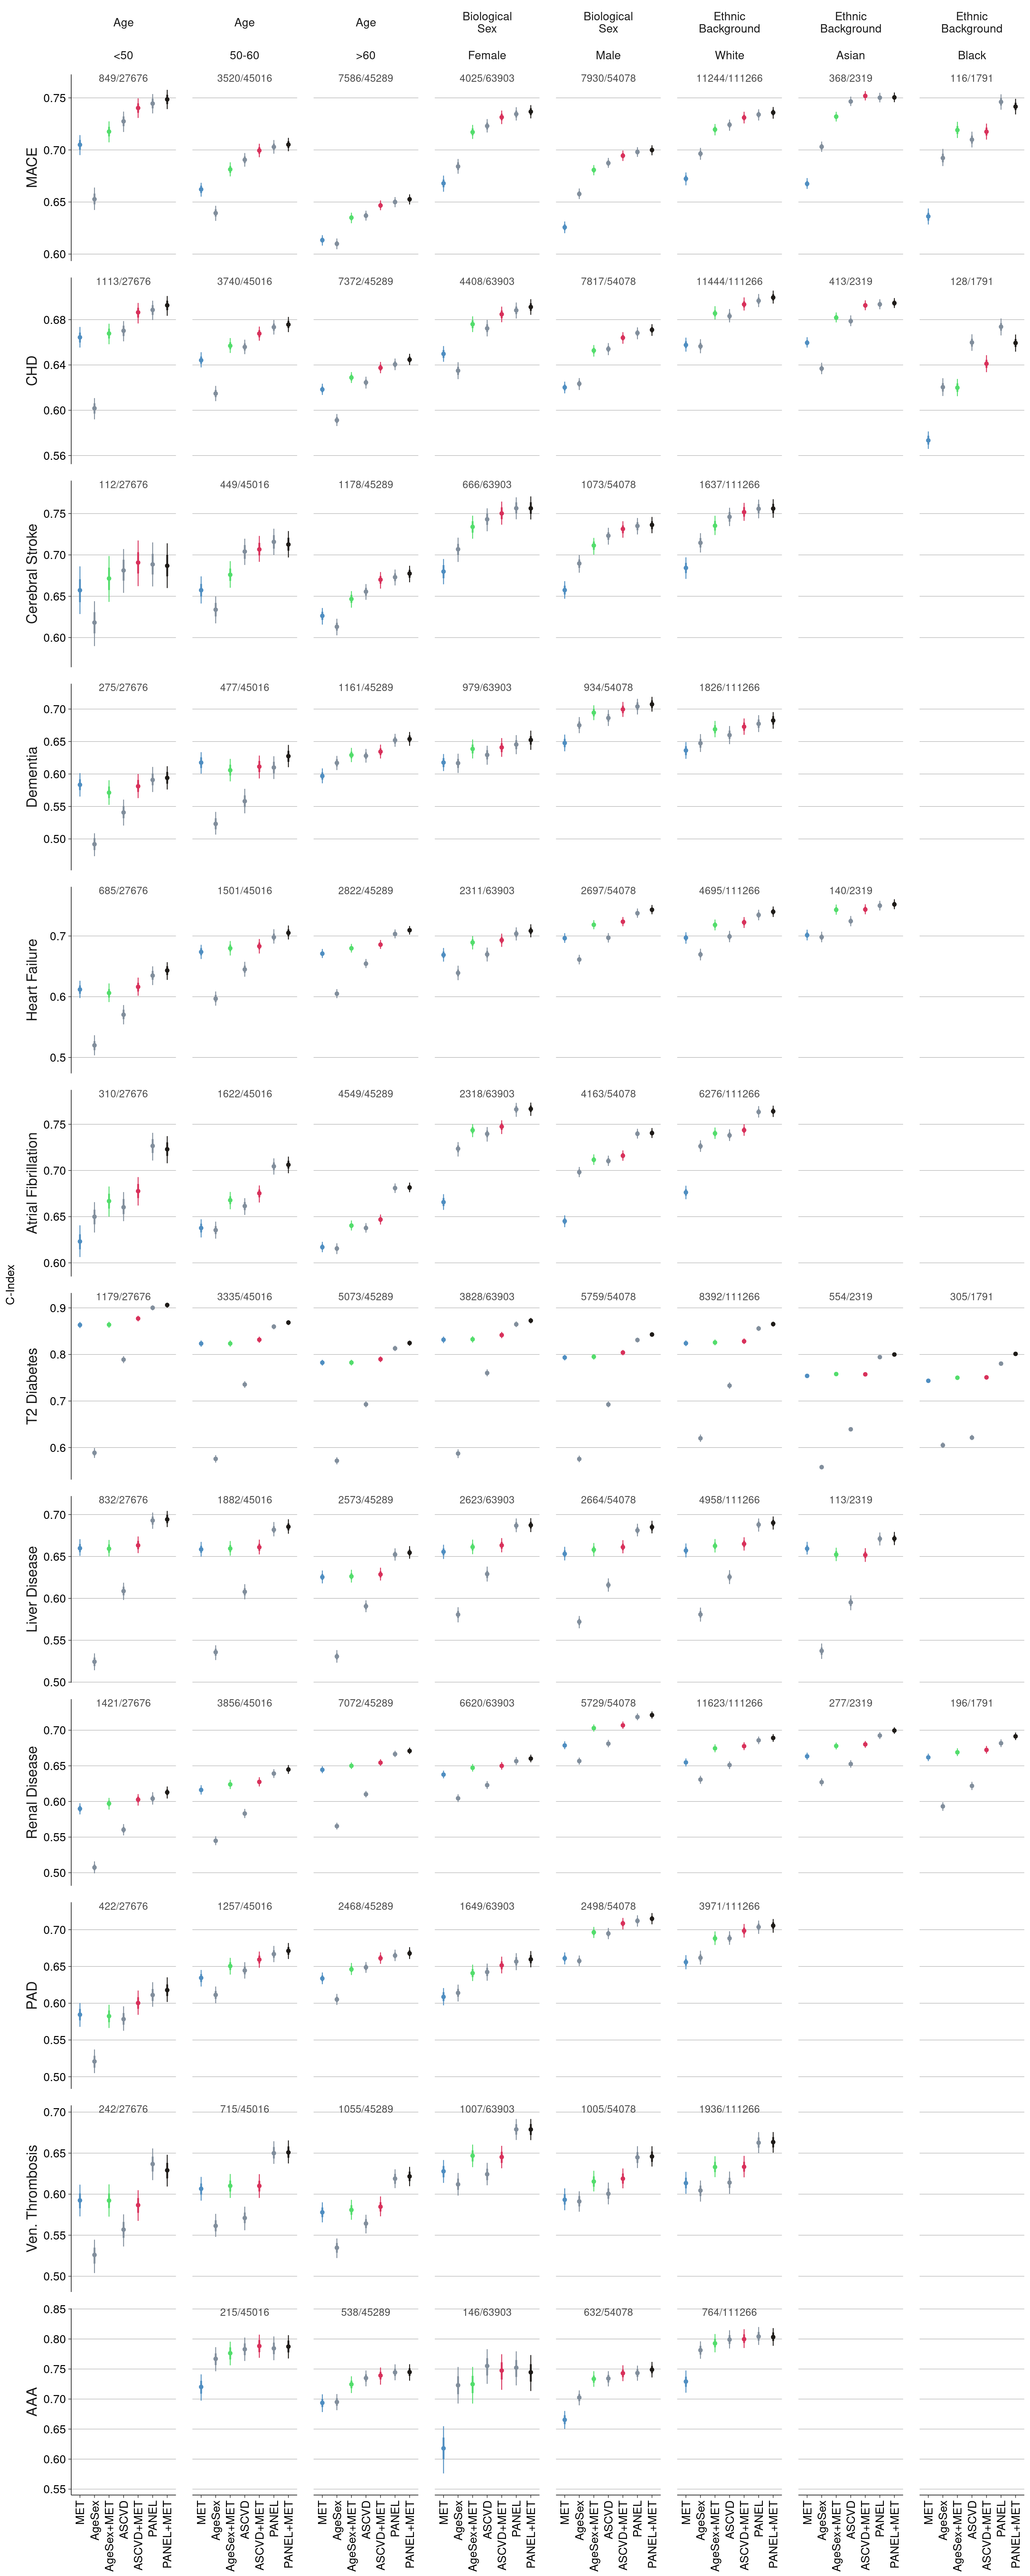

In [121]:
plot_width=10; plot_height=25; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)

temp_1 = temp %>% filter(endpoint %in% (endpoint_order %>% head(12)))
temp_labels = temp_1 %>% filter(score=="DS_PANEL+Metabolomics") %>% group_by(endpoint, group, subgroup, events_sg, len_sg, label) %>% summarise(median_cindex = median(cindex))

met_1 = plot_performance(temp_1, temp_labels)

met_1

`summarise()` has grouped output by 'endpoint', 'group', 'subgroup', 'events_sg', 'len_sg'. You can override using the `.groups` argument.

Warning message:
“Ignoring unknown parameters: fill”


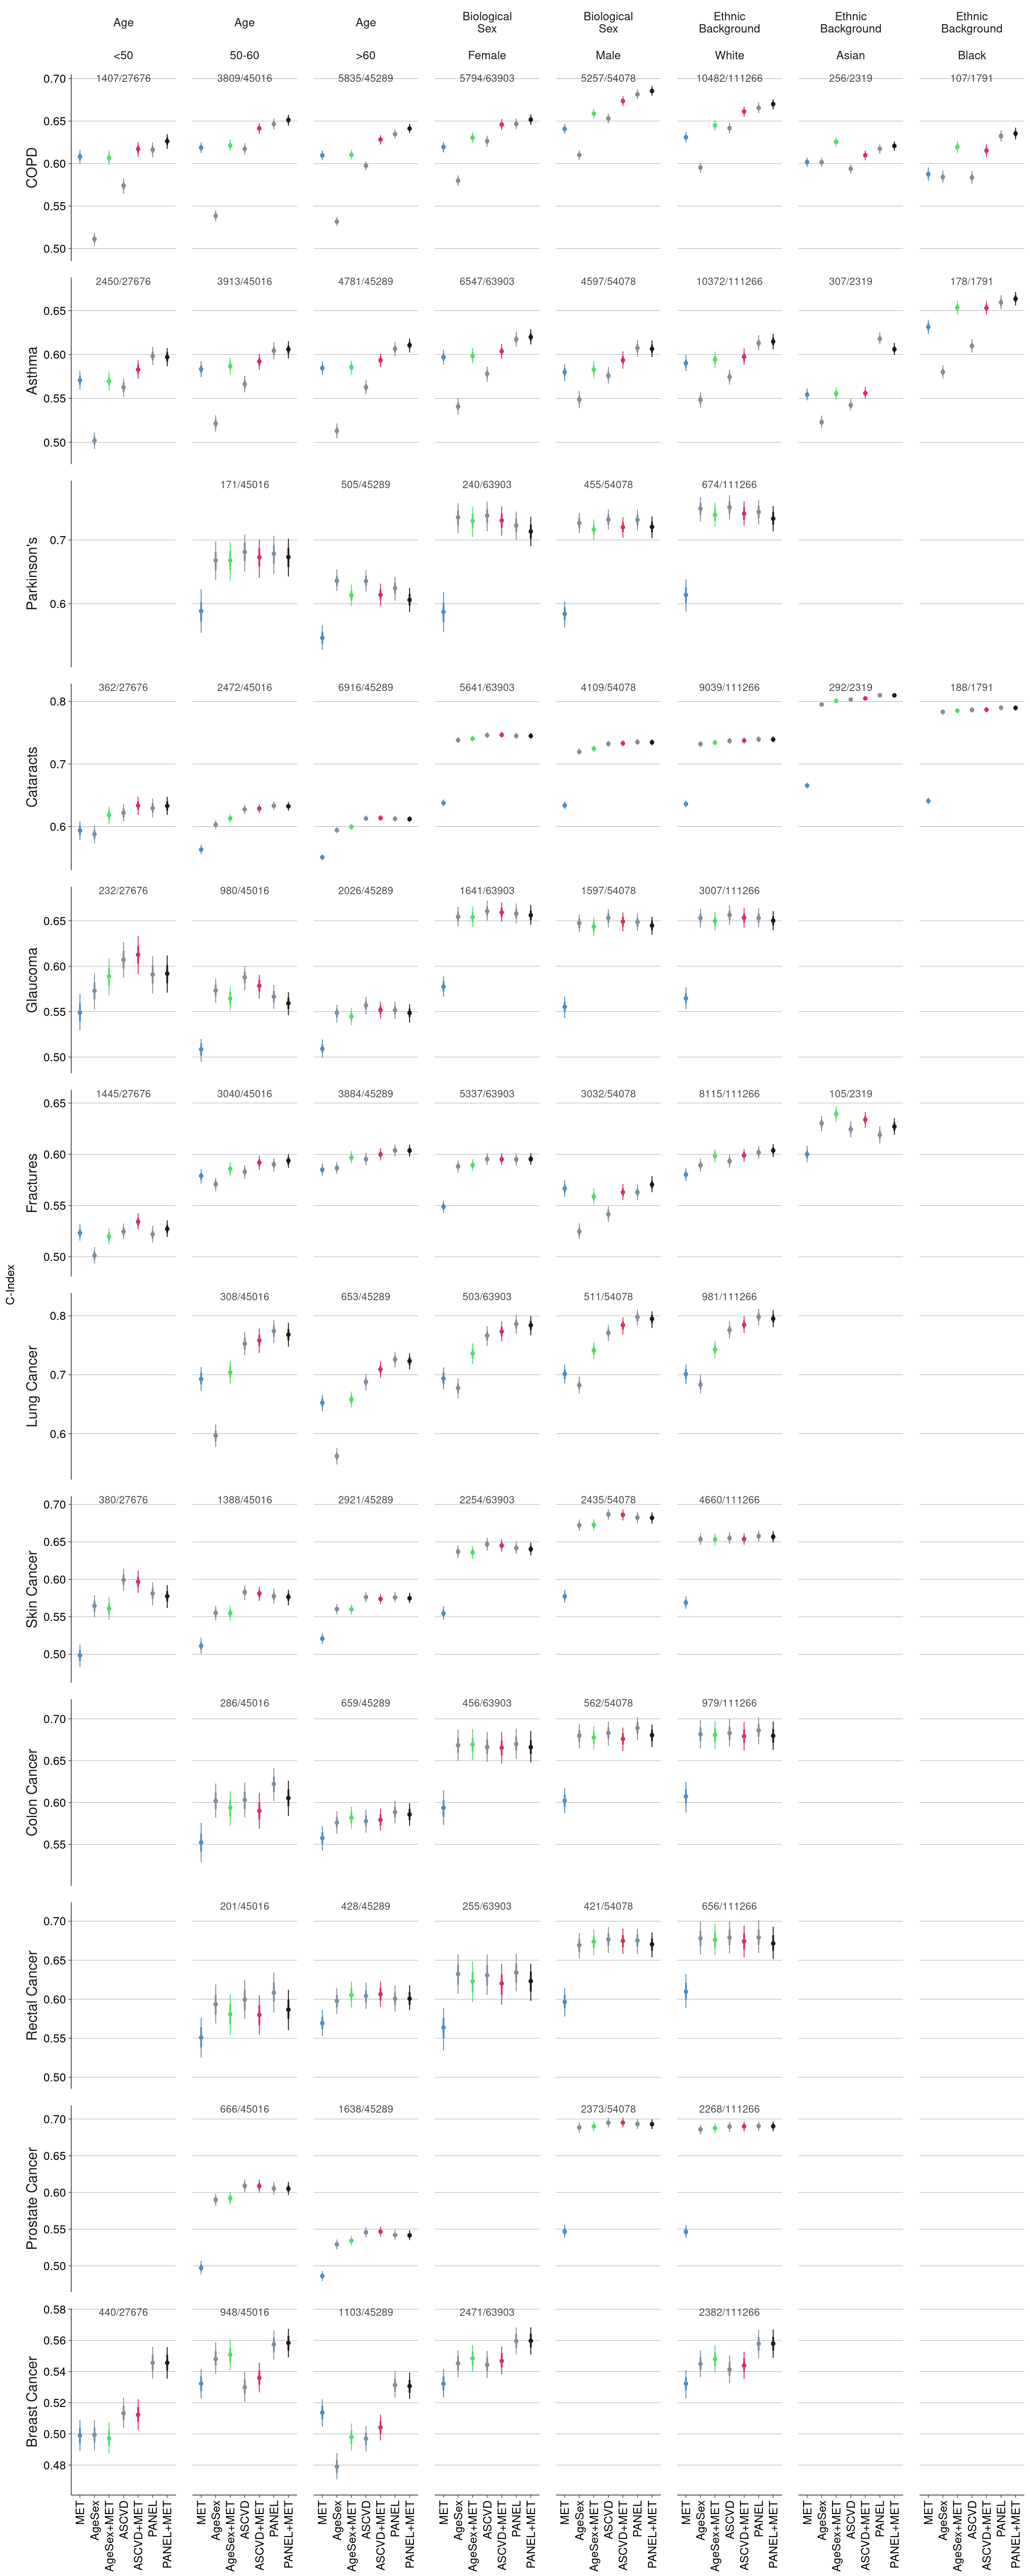

In [122]:
plot_width=10; plot_height=25; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)

temp_2 = temp %>% filter(endpoint %in% (endpoint_order %>% tail(12)))
temp_labels = temp_2 %>% filter(score=="DS_PANEL+Metabolomics") %>% group_by(endpoint, group, subgroup, events_sg, len_sg, label) %>% summarise(median_cindex = median(cindex))

met_2 = plot_performance(temp_2, temp_labels)

met_2

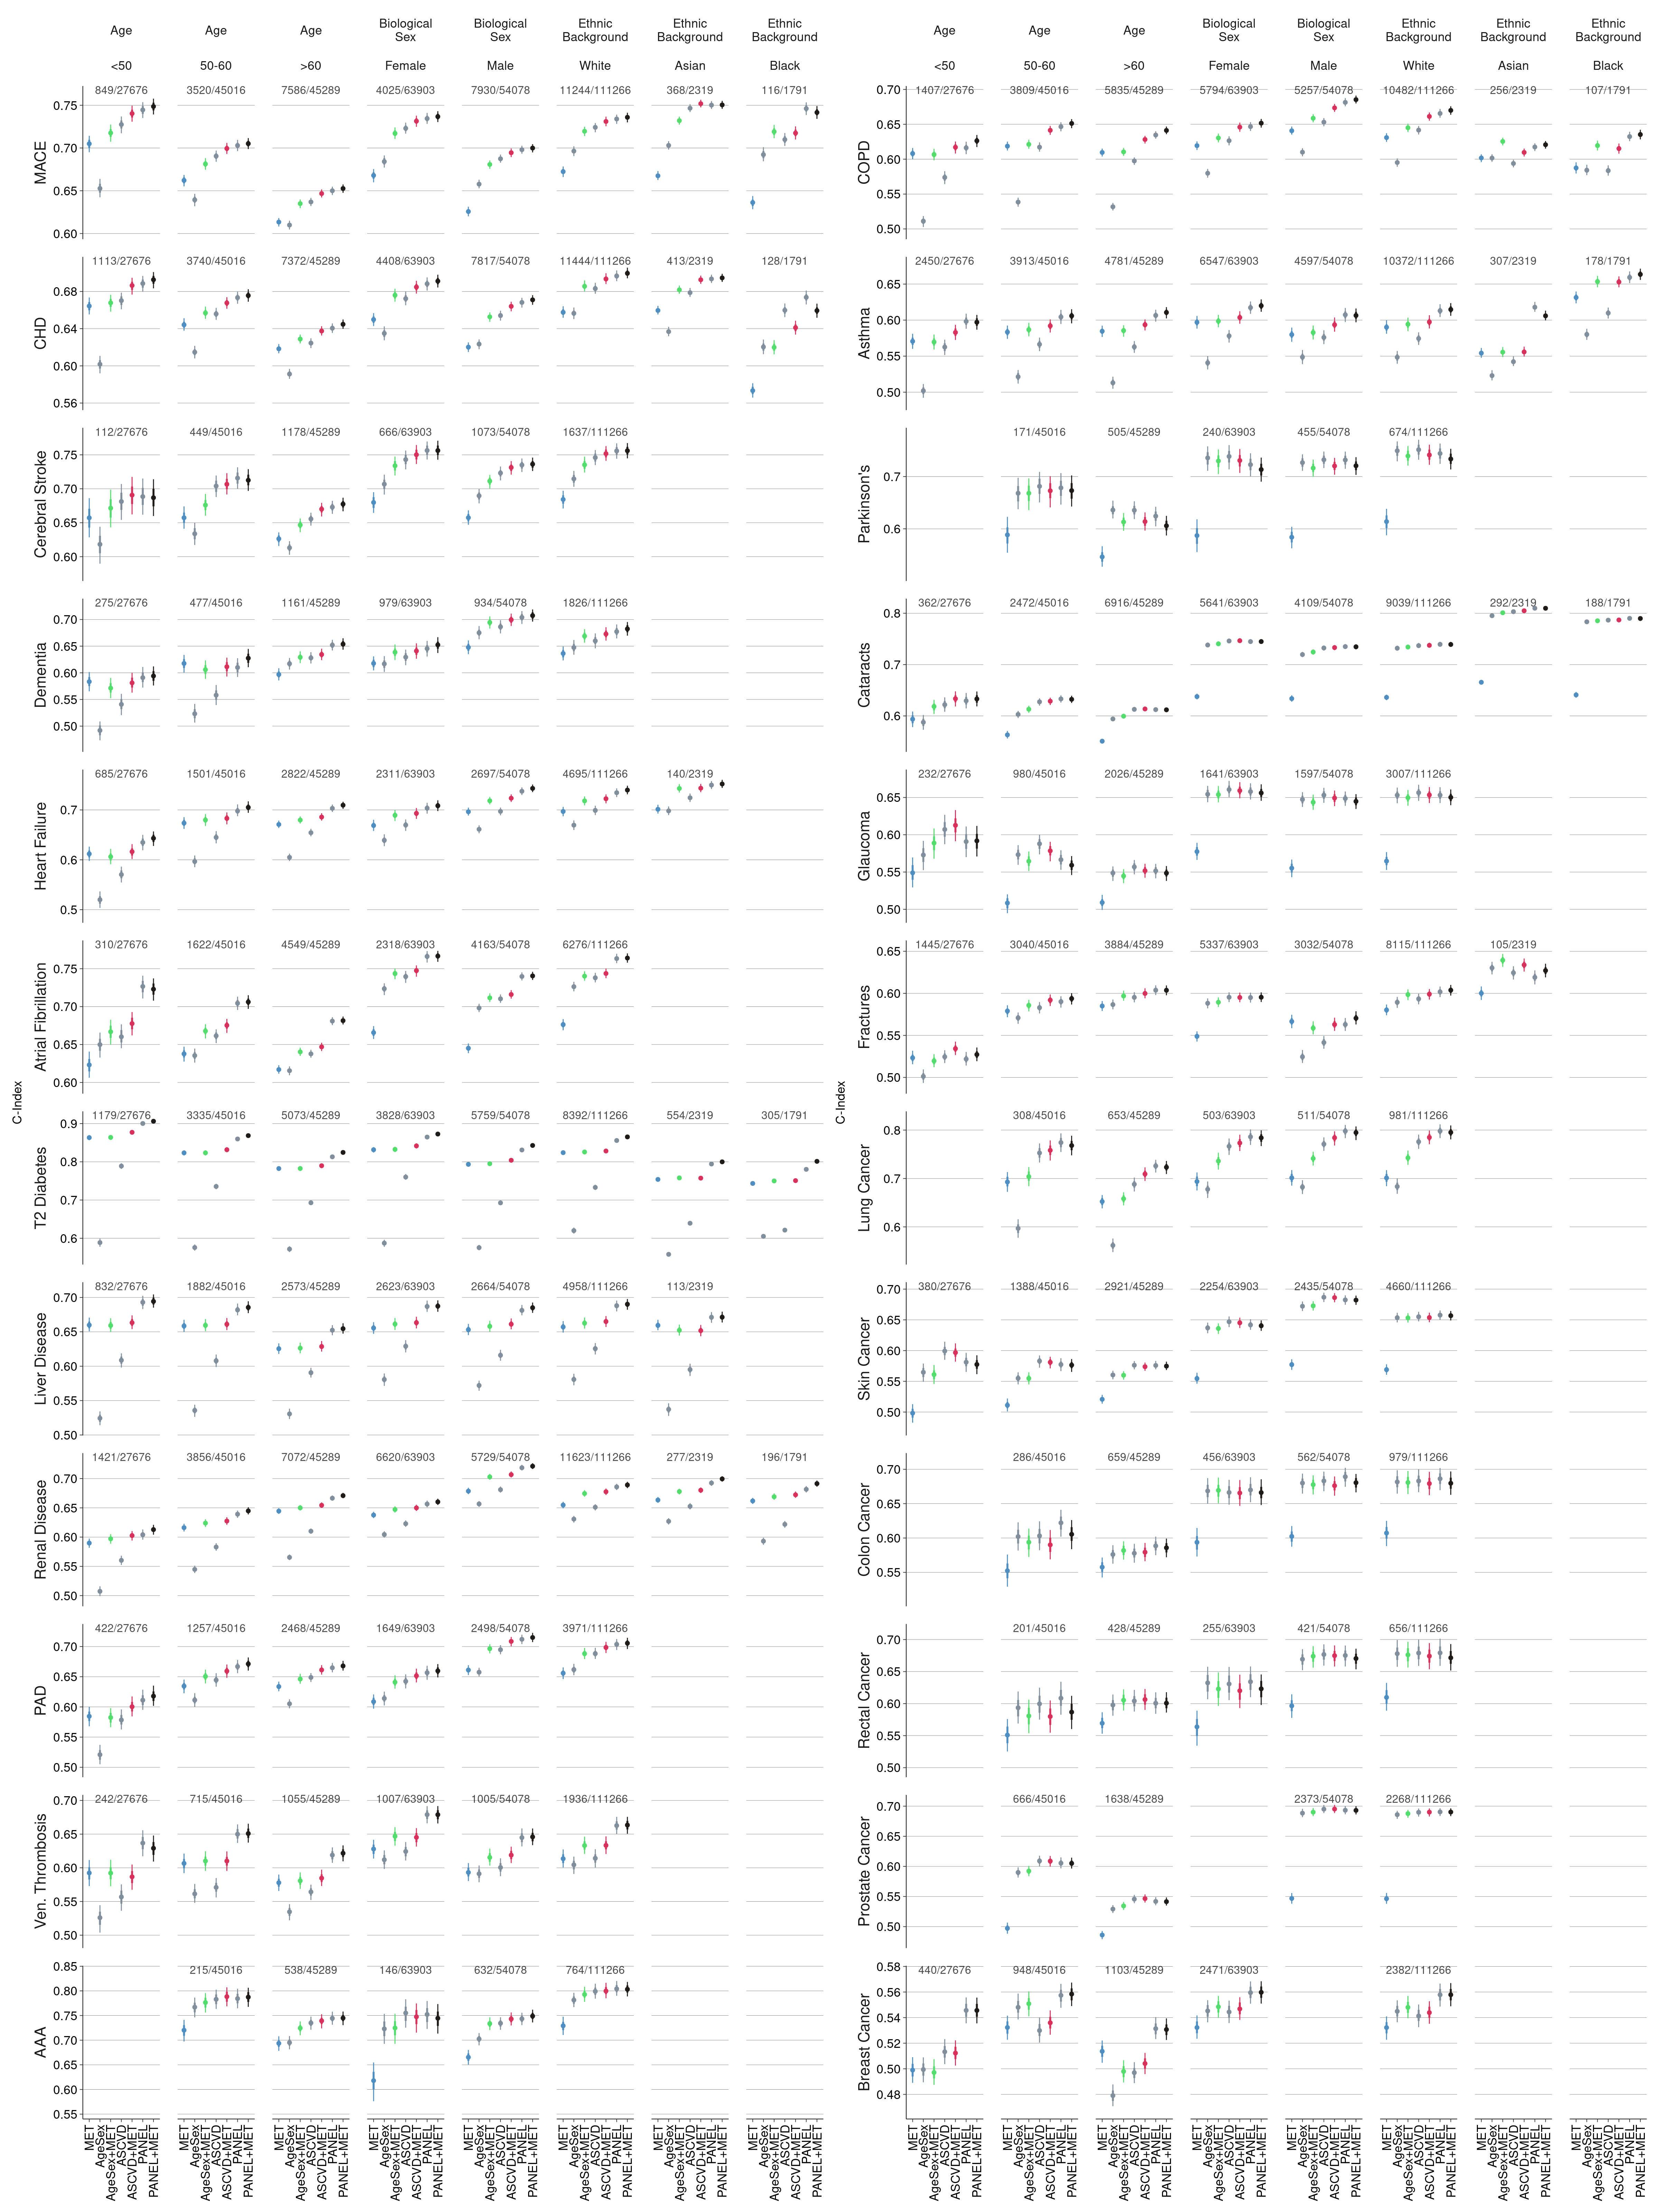

In [123]:
plot_width=15; plot_height=20; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)
fig_sgs = met_1|met_2
fig_sgs

In [127]:
library(gt)
plot_name = "Suppl_Figures_5_SubgroupPerformance"
fig_sgs %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_dpi)